In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
# Train
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
# Test
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Input: 1x28x28 (MNIST images)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64x4x4 #Output was 64x3x3
            nn.ReLU(),
            nn.Flatten(),  # Flatten to 64*4*4 = 1024 #Flatten to 64*3*3 = 576
            nn.Linear(1024, latent_dim)  # Output: latent_dim #nn.Linear(576, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),  # Output: 1D tensor 1024 #nn.Linear(latent_dim, 576)
            nn.Unflatten(1, (64, 4, 4)),  # Reshape to 3D 64x4x4 tensor #nn.Unflatten(1, (64, 3, 3))
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 16x14x14
            nn.ReLU(),
            # Adjusted the final ConvTranspose2d layer to output 28x28 images
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=3, output_padding=1),  # Output: 1x28x28
            nn.Sigmoid()  # Ensure output is in the range [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x) # size is 10
        reconstructed = self.decoder(latent)
        return reconstructed

In [5]:
batch_size = 128
model = ConvAutoencoder(latent_dim=10).cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
num_epochs = 5

In [6]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        # ===================forward=====================

        #print(img.shape)
        output = model(img)
        #print(output.shape)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/5], loss:0.4954
epoch [2/5], loss:0.4817
epoch [3/5], loss:0.4768
epoch [4/5], loss:0.4726
epoch [5/5], loss:0.4698


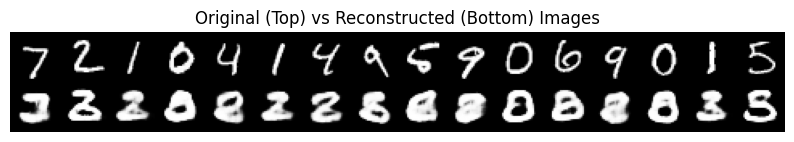

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image

# Load the MNIST test dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

# Load the trained model (assuming it's already defined and trained)
# model = ConvAutoencoder(latent_dim=10)
# model.load_state_dict(torch.load('autoencoder.pth'))  # Load saved weights if needed
model.eval()  # Set the model to evaluation mode

# Obtain one batch of test images
for data in testloader:
    img, _ = data
    img = Variable(img).cpu()  # Move images to CPU (if using GPU, change to .cuda())

    # Forward pass: Get reconstructed images
    with torch.no_grad():  # Disable gradient computation
        output = model(img)

    # Save the original and reconstructed images in a grid
    save_image(torch.cat([img, output], dim=0), 'test_results1.png', nrow=img.shape[0])
    break

# Display the saved image
result_image = Image.open('test_results1.png')
plt.figure(figsize=(10, 5))
plt.imshow(result_image)
plt.axis('off')
plt.title('Original (Top) vs Reconstructed (Bottom) Images')
plt.show()